# DSFB Course Project: Predicting IPO Share Price

![](https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg)

image source : https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg

## Introduction

An Initial Public Offering (IPO) is the process by which a private company becomes publicly traded on a stock exchange. The IPO company offers its shares to public investors in exchange of capital for sustaining expansion and growth. For this reason, IPOs are often issued by small or young companies, but they can also be done by large  companies looking to become publicly traded. During an IPO, the company obtains the assistance of an investment bank (underwriter), which helps determine the type, amount and price of the shares being offered. Decisions about the offering price are particularly important to avoid incurring excessive costs and maximize the capital received in the IPO. However at the end of the first trading day, price of each share can change due to market dynamics, which can lead to a price higher or lower than the offering one.

During an Initial Public Offering (IPO), the firm’s management have to disclose all relevant information about their business in a filing with the government called the "IPO Prospectus." Although there might be concerns about the public disclosure of sensitive information in the Prospectus that can help competitors, firms are encouraged to be as transparent as possible in order to avoid future litigation (lawsuits). A key textual field from the prospectus is:

__Risk_Factors__: Firms have to disclose all relevant information about internal or external risk factors that might affect future business performances. This information is contained in the “Risk Factors” section of the IPO prospectus. 

The key pricing variables are:

__Offering_Price__: the price at which a company sells its shares to investors.

__Num_Shares__: the total number of outstanding shares.

__Closing_Price__: (at the end of the first day of training) price at which shares trade in the open market, measured at the end of the first day of trading.

In this project you are provided with IPO data of different firms that are collected from different sources. You can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of other variables can be found in *variable_description.xlsx*.

This Notebook will be presented as follow :

# Part 1 :
# Part 2 :
# Part 3 :
# Part 4 :

In [3]:
import pandas as pd     
import seaborn as sns
import numpy as np
import re as re
import nltk
import datetime as dt

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from model_helpers import *
from datetime import datetime, timedelta
from sklearn.base import TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
from Plot_functions import *
from preprocessing_functions import *

## 0.1 Import Dataset 

##### Import,  explore dataset and check missing values

In [4]:
#read dataset
DATA_FOLDER = 'data'

#Cost TIME
ipo = pd.read_csv(DATA_FOLDER+'/data_non_textual_clean.csv')
ipo_predict = pd.read_csv(DATA_FOLDER+'/data_non_textual_clean_predict.csv')

ipo_text =  pd.read_csv(DATA_FOLDER+'/data_textual_clean.csv')
#ipo_text_predict = pd.read_csv(DATA_FOLDER+'/data_textual_clean_predict.csv)

In [5]:
ipo.shape

(3000, 5742)

In [6]:
ipo.columns[ipo.isna().any()].tolist()

[]

In [7]:
ipo_predict.shape

(474, 5742)

In [8]:
ipo_text.shape

(200, 501)

### Risk_Factors :  Textual description of all the risk / done 


In [4]:
risks = process_text_columns(ipo['Risk_Factors'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
print(risks)

(0       risk factor invest common stock involv high de...
1       risk factor invest common stock involv number ...
2       risk factor addit inform contain prospectus fo...
3       risk factor invest share common stock offer he...
4       risk factor addit inform contain prospectus fo...
5       risk factor invest common stock involv high de...
6       risk factor addit inform prospectus follow fac...
7       risk factor invest share common stock involv v...
8       risk factor invest common stock involv high de...
9       risk factor invest class common stock involv s...
10      risk factor addit inform set forth prospectus ...
11      risk factor addit inform set forth prospectus ...
12      risk factor consid care follow risk factor inf...
13      risk factor read care discuss materi risk rela...
14      risk factor invest common stock involv high de...
15      risk factor invest common stock involv high de...
16      risk factor care consid risk describ make inve...
17      risk 

In [25]:
#convert to a dataframe
risks = pd.DataFrame(risks[0])
print(risks)

KeyError: 0

### TFIDF

In [7]:
# TFIDF --------------------------------------------------------------------------------------------
# Il faut reprendre depuis le CSV !!!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 500)
risks_tfidf = vectorizer.fit_transform(risks)
risks_tfidf = risks_tfidf.toarray()

#Convert to a dataframe
risks_tfidf = pd.DataFrame(risks_tfidf)

In [8]:
columnToDrop = [] 
columnToDrop.append('Risk_Factors')

### Final check for the Nan



In [30]:
print(ipo['Target'])

KeyError: 'Target'

In [11]:
len(ipo)

2999

In [12]:
ipo.isnull().values.sum()

0

In [13]:
print(columnToDrop)

['Risk_Factors']


In [ ]:
#ipo_processing.drop(columns,inplace=True,axis=1)

In [ ]:
#ipo_processing.isnull().values.sum()

In [ ]:
"""import seaborn as sns

# Visualize pattern of missing data
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ipo_processing.isnull(), cbar=False)"""

In [ ]:
#ipo_processing.columns[ipo_processing.isna().any()].tolist()

In [ ]:
#len(ipo_processing.columns)

## 0.9 : TARGET

In [17]:
ipo['Target'] = ipo.Closing_Price >= ipo.Offering_Price 

In [18]:
len(ipo.Closing_Price == ipo.Offering_Price )

3000

In [19]:
len(ipo['Target'])

3000

In [20]:
ipo.Target = ipo.Target.astype(int)

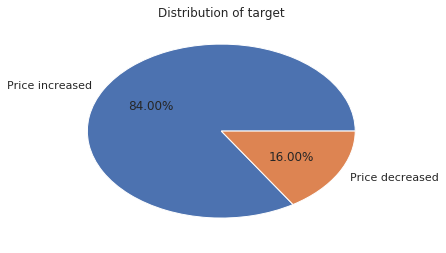

In [21]:
counts = ipo.Target.value_counts()

sns.set()

ones = counts[1]/len(counts) * 100
zeros = counts[0]/len(counts) * 100
labels = 'Price increased', 'Price decreased'
plt.pie( [ones, zeros], labels=labels, autopct='%1.2f%%', startangle=360)
plt.title('Distribution of target')
plt.show()

# Pour le preprocessing Je pense qu'il manque: Num_Shares, lockup_days, lockup_date Mais Num_shares est-ce qu'on l'utilise pour le target et donc pas pour les features?

## 0.7 Features Reduction

### 1. Check the correlation with the target
    -> Drop bottom 5%
### 2. Check the correlation between feature
    -> Drop 
    
### 0.7.1. Check the correlation of the features


In [14]:
ipo.drop(columnToDrop,inplace=True,axis=1)
ipo.head()

,Unnamed: 0,Closing_Price,Num_Shares,Offering_Price,SEC_fee,SP1,SP3,acc_fee,amd_hp,amd_lp,...,S&L,Sanitation,TV,Telecom,Telephone Commun,Thrift,Transportation.1,Water Supply,Wholesale,Target
0,0,18.5000,20673000.0,15.0,10369.0,1423.54,2001.57,1100000.0,14.0,12.0,...,0,0,0,0,0,0,0,0,0,1
1,1,12.8500,36762000.0,13.0,25529.0,796.53,1389.08,1500000.0,17.0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,2,16.5000,7000000.0,15.0,13173.0,328.45,937.91,200000.0,15.0,13.0,...,0,0,0,0,0,0,0,0,0,1
3,3,11.0625,10923000.0,8.5,10542.0,321.48,963.04,885000.0,9.0,8.0,...,0,0,0,0,0,0,0,0,0,1
4,4,12.3750,5350000.0,12.0,7527.0,307.76,938.79,100000.0,12.0,10.0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# check if only numbers inside the dataframe
print(ipo.dtypes.unique())

[dtype('int64') dtype('float64') dtype('int32')]


In [16]:
# compute the correlation matrix
corr = ipo.corr(method='pearson').abs()
print(type(corr))

                   Unnamed: 0  Closing_Price  Num_Shares  Offering_Price  \
Unnamed: 0           1.000000       0.022224    0.008303        0.020552   
Closing_Price        0.022224       1.000000    0.172350        0.704178   
Num_Shares           0.008303       0.172350    1.000000        0.286147   
Offering_Price       0.020552       0.704178    0.286147        1.000000   
SEC_fee              0.000406       0.139149    0.660417        0.300970   
SP1                  0.001887       0.004239    0.164643        0.141665   
SP3                  0.001468       0.138985    0.162498        0.151284   
acc_fee              0.000792       0.029235    0.229024        0.117271   
amd_hp               0.022053       0.599818    0.288928        0.950233   
amd_lp               0.024753       0.603943    0.281578        0.951230   
amd_mp               0.023403       0.602903    0.285883        0.952433   
amd_pr_amt           0.008381       0.146075    0.595625        0.338341   
amd_pr_shs_p

In [17]:
#convert corr to a dataframe 
#corr = pd.DataFrame(corr[0])
#corr = pd.DataFrame(corr)
corr.head()

<class 'pandas.core.frame.DataFrame'>


In [ ]:
"""#Save correlation matrix into the DATA Folder
np.save('/DATA/correlation_matrix.npy',corr)
#Load correlation matrix
corr_matrix = np.load('/DATA/correlatioin_matrix.npy')"""

In [18]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# print the features to drop 
print(to_drop)

['amd_hp', 'amd_lp', 'amd_mp', 'book_proceeds_ovt', 'dj_avg_1', 'filing_date', 'h_fil_p', 'l_fil_p', 'lastamd_tot', 'm_fil_p', 'num_bokr_up', 'num_funds_vexp', 'ord_shs', 'pctchg_sp_4', 'prim_amt', 'prim_shs_1', 'prim_shs_3', 'proceeds_1', 'proceeds_2', 'proceeds_3', 'quiet_period', 'shrout_crsp', 'shs_offered_1', 'shs_offered_2', 'tot_amt', 'tot_proceeds', 'tot_shs_offered', 'amd_nbr', 'offer_date_timestamp', 'description_numeric', 'Bangor', 'Bayonne', 'Buffalo', 'Charles Town', 'Chatham', 'Cherry Hill', 'Dalian', 'Danyang, Jiangsu', 'Georgetown, Massachusetts', 'Great River', 'Greenwood', 'Honolulu', 'Huizhou City, Guangdong', 'Indiana.1', 'Lenexa', 'Loudon', 'Loveland', 'Matawan', 'Mount Pleasant', 'North Huntingdon', 'Panama', 'Petach-Tikva', 'Pryor', 'Sacramento', 'Saddle Brook', 'Shrewsbury', 'Sioux Falls', 'Washington.1', 'Wellington', 'West Fargo', 'Williamsburg, Virginia', 'Yonkers', 'Analytical & Scientific Instrumentation', 'Biotech Related Animal Health & Nutrition Products

In [19]:
# numbers of features to drop
print(len(to_drop))

1359


##### Vizualisation of the correlation matrix  ( to test with better pc )

In [ ]:
"""def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(df)"""

In [ ]:
#Heatmap version
#sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

MemoryError: 

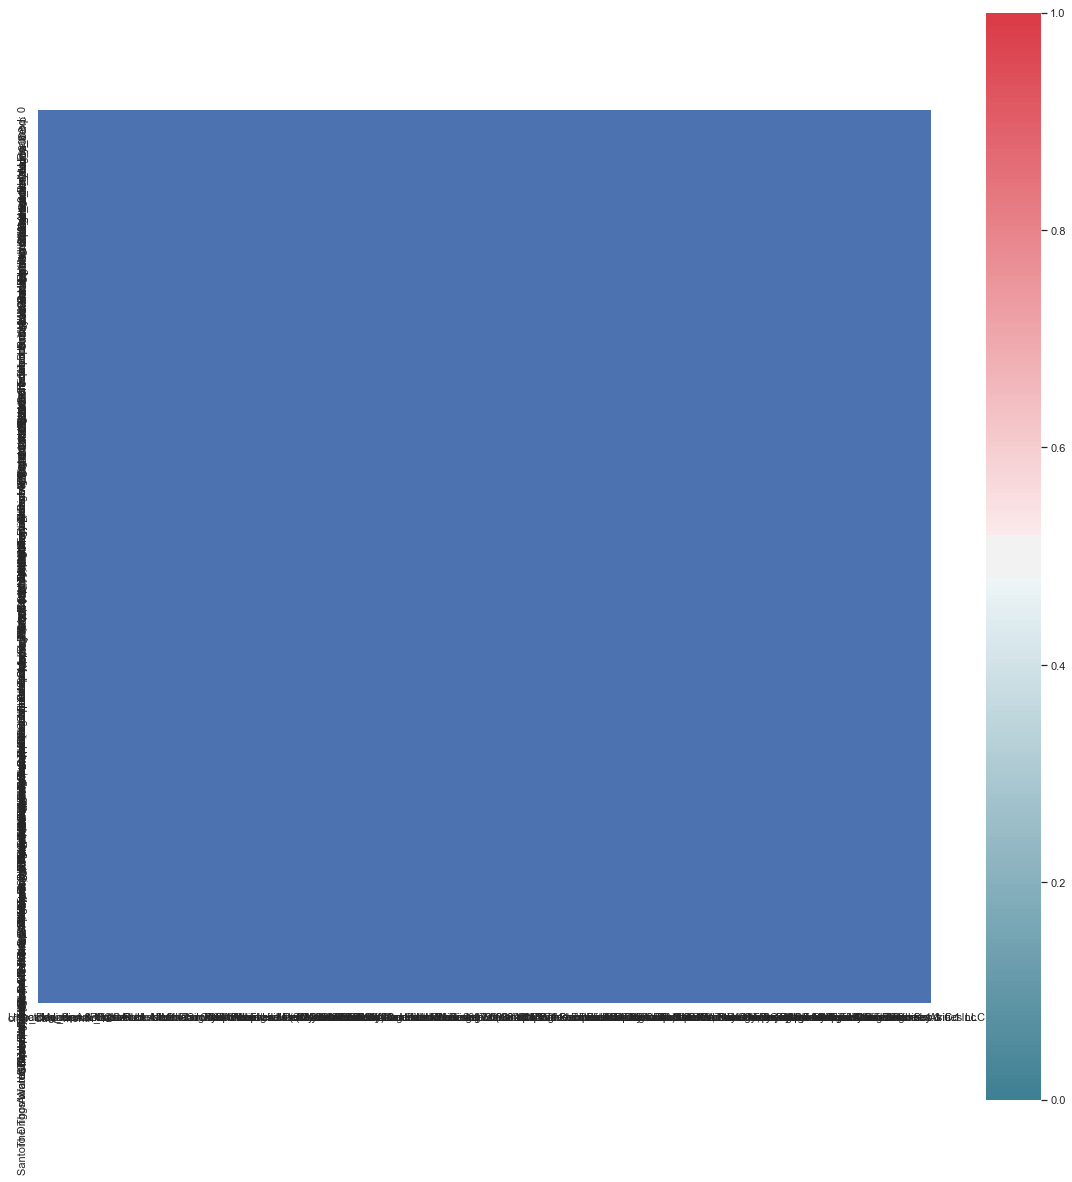

In [19]:
#import matplotlib as plt
# Print correlation Matrix
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
# Drop the features
ipo.drop(to_drop,inplace=True,axis=1)

##### Now we redo the same steps for the risks factors

In [ ]:
print(risks_tfidf.dtypes.unique())
risks_tfidf.head()

In [ ]:
# compute the correlation matrix
risk_corr = risks_tfidf.corr(method='pearson').abs()
print(type(risk_corr))

In [ ]:
#convert corr to a dataframe 
#risk_corr = pd.DataFrame(risk_corr[0])
#corr = pd.DataFrame(corr)
risk_corr.head()

In [ ]:
# Select upper triangle of correlation matrix
upper = risk_corr.where(np.triu(np.ones(risk_corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
risk_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# print the features to drop 
print(risk_to_drop)

### 0.7.2. Check the correlationwith the Target


In [23]:
#import matplotlib.pyplot as plt
dict_corr = corr.Target.to_dict()
for w in sorted(dict_corr, key=dict_corr.get, reverse=True):
    print (w, dict_corr[w])

price_range 0.21767499710231356
Closing_Price 0.2061645958685627
gross_spread 0.14881704132388227
quiet_period 0.14480371288154334
offer_date_timestamp 0.14474229435325314
filing_date 0.14060077794033737
exp_pctofproceeds 0.1360025350807256
SP1 0.1332070940400942
ipo_yr_ritt 0.12146569193795971
rate 0.12145989812786254
Offering_Price 0.12073392735753721
prim_shs_2 0.1173744897048651
lockup_days 0.11206061594309587
dj_avg_1 0.11173243296805423
num_mgrs 0.0971258733390998
amd_nbr 0.09425258366095982
num_amd 0.09409338283959533
No 0.09100512611310543
Yes 0.09100512611310543
SP3 0.08641269086875038
tang_ce_1 0.0847419459052309
offer_date_year_2008 0.08381966800870615
Services 0.07806361937388491
mgt_fee 0.07168214492160953
offer_date_year_2014 0.07124402562443802
book_proceeds_ovt 0.06983663109848356
pctchg_nasdaq_1 0.06919873038929153
gross_spread_allmkt 0.0666459296553073
num_bokr_up 0.06605328236770247
num_bokr 0.06588767120028771
pctchg_sp_3 0.06493370936569452
tang_ce_2 0.064072404135

#### Since the correlation between the features and the Target is always 0.25 We decide to keep all of our features

 _________________________________________________________ 
## Part 1

Predict whether the closing price is higher than the offering price using non-text fields. By non-text fields, we mean all fields except the 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(non-text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

On doit peut être mettre tous les modèles dans un autre notebook si on va les utiliser dans les autres parties

In [ ]:
## J'enlève les dates en attendant
ipo_processing.drop( columns = ['lockup_date','lockup_days','Closing_Price','Offering_Price','first_trade_date','offer_date','issue_date'],inplace = True)

In [23]:
target = ipo['Target'] 
features = ipo.drop(['Risk_Factors','Target'],axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

# Separate target and features into test and training and validation sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

### Dummy classifier

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

bbaseline_clf = DummyClassifier(strategy='stratified', random_state = seed)

# Fit the dummy classifier 
bbaseline_clf.fit(X_train,y_train)

# Predict target probabilities of belonging to positive class
y_pred = bbaseline_clf.predict_proba(X_test)

# Compute area under the curve score
baseline = roc_auc_score(y_test, y_pred[:,1])
print('auc',baseline)

plot_roc_curve('Dummy',y_pred)

### Logistic Regression

In [ ]:
baseline_clf = LogisticRegression() 
baseline_clf.fit(X_train,y_train)
y_pred = baseline_clf.predict_proba(X_test)
print('Score ',roc_auc_score(y_test, y_pred[:,1]))
plot_roc_curve('Logistic Regression',y_pred)

### Logistic regression tuning c penalty 

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Standardize features and classifier in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict_proba(X_test)
    scores.append(roc_auc_score(y_test, y_train_pred[:,1]))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train,y_train)
y_pred_lr = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_lr[:,1])
print ('lr classifer auc with l1 regularization = %2.4f' %score)
plot_roc_curve('l1 regularization',y_pred_lr)

### KNN tuning N neighbors

In [ ]:
# Standardize features and classifier in a single pipeline
from sklearn.neighbors import KNeighborsClassifier

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_clf', KNeighborsClassifier()))
pipeline = Pipeline(estimators)

# Finding best value of K using validation set
scores = []
Ks = []
for K in [int(i) for i in np.linspace(5, 95, 10)]:
    pipeline.set_params(knn_clf__n_neighbors = K) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    Ks.append(K)

best_K = Ks[scores.index(max(scores))]
print ('best K = %d with auc score = %2.4f' %(best_K, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(knn_clf__n_neighbors = best_K)
pipeline.fit(X_train,y_train)
y_pred_knn = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_knn[:,1])
print ('knn classifer auc = %2.4f' %score)
plot_roc_curve('KNN',y_pred_knn)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define a random classifier pipeline
estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(rf_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(rf_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_rf = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_rf[:,1])
print ('rf classifer auc = %2.4f' %score)

In [ ]:
plot_roc_curve('KNN',y_pred_rf)

###  Gradient Boosting classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define a random classifier pipeline
estimators = []
estimators.append(('gb_clf', GradientBoostingClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(gb_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(gb_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(gb_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_gb = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_gb[:,1])
plot_roc_curve('GradientBoostingClassifier',y_pred_gb)

In [ ]:
print(score)

## Part 2

Predict whether the closing price is higher than the offering price using __only__ textual field 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

##### Get textual features

In [16]:
#Copy dataframe
text_features = ipo_text.copy()
text_target = target[0:len(text_features)]

NameError: name 'target' is not defined

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = 1, seed = 0):

    # Cross-validation schema for inner and outer loops (stratified if it is a classification)
    inner_cv = KFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
    outer_cv = KFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)
    
    # Grid search to tune hyper parameters
    est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)

    # Nested CV with parameter optimization
    nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)
    
    print('Average score: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))

In [ ]:
# Dataframe of Risk Factors :  risks_tfidf    
features = risks_tfidf
seed = 0

warnings.filterwarnings('ignore')
seed = 0

# Define pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_clf__random_state = seed)

# Fixed parameters
score = 'accuracy'

# Setup possible values of parameters to optimize over
p_grid = {"rf_clf__n_estimators": [int(i) for i in np.linspace(10.0, 50.0, 5)]}

nested_cv(X = features, y = target, est_pipe = rf_pipe, p_grid = p_grid, p_score = score, n_cores = -1)

### PCA

In [ ]:
# Regroupe to 50 Fields 
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

principalComponents = pca.fit_transform(risks_tfidf)
principalComponents = pd.DataFrame(principalComponents)



#Update the name of the columns
# get length of df's columns
num_cols = 100
# generate range of ints for suffixes
rng = range(0,num_cols)

new_cols = [ 'risk_'+str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
principalComponents.columns = new_cols[:num_cols]

principalComponents.head()

In [ ]:
features = principalComponents
seed = 0

warnings.filterwarnings('ignore')
seed = 0

# Define pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_clf__random_state = seed)

# Fixed parameters
score = 'accuracy'

# Setup possible values of parameters to optimize over
p_grid = {"rf_clf__n_estimators": [int(i) for i in [10, 20, 50, 100]]}

nested_cv(X = features, y = target, est_pipe = rf_pipe, p_grid = p_grid, p_score = score, n_cores = -1)


## Word Vectors : Word2Vec

In [ ]:

nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


def review_to_wordlist( review ):
    
    review_text = BeautifulSoup(review).get_text()
   
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    words = review_text.lower().split()
    
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(w) for w in words]
    
    return(words)

In [ ]:
# Define a function to split a review into parsed sentences, where each sentence is a word list

def review_to_sentences( review, tokenizer ):
    
    raw_sentences = tokenizer.tokenize(review.strip())  
    sentences = []
    for raw_sentence in raw_sentences:      
        if len(raw_sentence) > 0:           
            sentences.append( review_to_wordlist( raw_sentence ))
   
    return sentences

In [ ]:

sentences = []
risks = ipo['Risk_Factors']
for risk in risks:
    sentences += review_to_sentences(risk, tokenizer)

In [ ]:
# Train word vectors

warnings.filterwarnings('ignore')

# Set values for various parameters
num_features = 300    # word vector dimensionality                      
min_word_count = 40   # minimum word count                        
num_workers = 16      # number of threads to run in parallel
context = 10          # context window size                                                                                    

# Initialize and train the model 
from gensim.models import word2vec
print ('Training model...')
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
print ('Done !')

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient
w2v_model.init_sims(replace=True)
 

In [ ]:
# Function to average all of the word vectors in a given paragraph

def makeFeatureVec(words, model, num_features):
    
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype='float32')
    nwords = 0.
     
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:

# Given a set of reviews (each one a list of words), calculate 
# the average feature vector for each one and return a 2D numpy array

def getAvgFeatureVecs(reviews, model, num_features):
    
    # Initialize a counter
    counter = 0
    
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype='float32')
     
    # Loop through the reviews
    for review in reviews:
       
       # Print a status message every 1000th review
       if counter%1000 == 0:
           print ('Review %d of %d' % (counter, len(reviews)))
       
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       
       # Increment the counter
       counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# Calculate average feature vectors for review data,
# using the functions we defined above.

clean_data_reviews = []
for review in ipo['Risk_Factors']:
    clean_data_reviews.append( review_to_wordlist( review ))

w2v_features = getAvgFeatureVecs( clean_data_reviews, w2v_model, num_features )

In [ ]:

%%time
warnings.filterwarnings('ignore')
seed = 0

# Define pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_clf__random_state = seed)

# Fixed parameters
score = 'accuracy'

# Setup possible values of parameters to optimize over
p_grid = {"rf_clf__n_estimators": [int(i) for i in np.linspace(10.0, 50.0, 5)]}

nested_cv(X = w2v_features, y = target, est_pipe = rf_pipe, p_grid = p_grid, p_score = score, n_cores = -1)


### Classification using Random Forest with Average Word2Vec Features

In [ ]:
%%time
warnings.filterwarnings('ignore')
seed = 0

# Define pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_clf__random_state = seed)

# Fixed parameters
score = 'accuracy'

# Setup possible values of parameters to optimize over
p_grid = {"rf_clf__n_estimators": [int(i) for i in np.linspace(10.0, 50.0, 5)]}

nested_cv(X = w2v_features, y = target, est_pipe = rf_pipe, p_grid = p_grid, p_score = score, n_cores = -1)

## Paragraph vectors : Doc2Vec


In [ ]:
# Doc2Vec needs each review to be tagged with some sort of ids
# Here we tag each review with the 'id' field

import gensim

tagged_clean_data_reviews = []
for uid, review in zip(data['id'], clean_data_reviews):
    tagged_clean_data_reviews.append(gensim.models.doc2vec.TaggedDocument(words=review, tags=['%s' % uid[1:-1]]))

## Part 3

Predict whether the closing price is higher than the offering price using __all__ fields. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(all-fields) -> Probability of being in class 1 
    
For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

#### Merge all features and get train, validate and test set

In [26]:
all_features = pd.concat([text_features, features], axis=1)

# Separate target and features into test and training and validation sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size = 0.2, random_state = seed)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

#### XGB gradient boosting

In [27]:
# Define pipeline
estimators = []
estimators.append(('xgb_clf', XGBClassifier()))
xgb_pipe = Pipeline(estimators)
xgb_pipe.set_params(xgb_clf__n_jobs = -1)
xgb_pipe.set_params(xgb_clf__random_state = seed)

# Fixed parameters
score = 'roc_auc'

# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    xgb_pipe.set_params(xgb_clf__n_estimators = NS) 
    xgb_pipe.fit(X_train_train,y_train_train)
    y_train_pred = xgb_pipe.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
xgb_pipe.set_params(xgb_clf__n_estimators = best_NS)
xgb_pipe.fit(X_train,y_train)
y_pred_gb = xgb_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_gb[:,1])
plot_roc_curve('GradientBoostingClassifier',y_pred_gb,y_test)

ValueError: feature_names must be unique

### Feed Forward Neural Network

In [28]:
# Fix random seed for reproducibility
np.random.seed(seed)

# Build neural network model
def create_model(nbr_l1, nbr_l2, nbr_l3):
    # create model
    model = Sequential()
    model.add(Dense(nbr_l1, input_dim=all_features.shape[1], activation='relu'))
    model.add(Dense(nbr_l2, activation='relu'))
    model.add(Dense(nbr_l3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 


warnings.filterwarnings('ignore')

nn_score = []
for i in range(3,7,1):
    nbr_l1 = pow(2,(i+2))
    nbr_l2 = pow(2,(i+1))
    nbr_l3 = pow(2,(i))
    model = create_model(nbr_l1, nbr_l2, nbr_l3)
    
    # Create pipeline using keras wrapper for sklearn
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('nn_clf', KerasClassifier(build_fn=create_model)))
    nn_pipe = Pipeline(estimators)
    nn_pipe.set_params(nn_clf__epochs = 2)
    nn_pipe.set_params(nn_clf__batch_size = 10)
    nn_pipe.set_params(nn_clf__verbose = 2)

    # Setup possible values of parameters to optimize over
    p_grid = {}

    # Fixed parameters
    score = 'roc_auc'

    # Train and evaluate model
    #Train the pipe
    nn_pipe.fit(X_train_train, y_train_train )
    # Get predicted values
    nn1_predict = nn_pipe.predict_proba(X_train_val)
    score = roc_auc_score(y_train_val, nn_predict[:,1])
    print("")
    nn_score.append(score)
    

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Part 4
  
Predict the share price at the end of the day using __all__ fields.

    f(all-fields) ->  Share price at the end of the first day of trading
    
For the evaluation metric, report statisitcs for R-squared, Residual Mean Squared Error, Mean Absolute Error, and Median Absolute Error; however, be sure to tune and hypertune your models using R-Squared.

## Data

As mentioned earlier, you can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of each variable can also be found in *variable_description.xlsx*.

## Requirements

We expect your solution for each step to contain the following:

* data preprocessing and feature extraction (can be shared across different steps)
* feature reduction
* train, tune and test different predictive models
* model comparison and arguing about the best model (don't forget mentioning a baseline model)
* predict the labels of the to_predict dataset using your final model
* discussion on possible additional tasks that can be done to boost the performance

## Deliverables

* Predict values from your *best* predictive model for the target variable in Parts 1 to 4 above, and insert those values into the file __*ipo_to_predict.xlsx*__ The fields to be completed by you are: __Price_Change_Non_Textual__ (Part 1), __Price_Change_Textual__ (Part 2), __Price_Change_All__ (Part 3), and __Price_All__ (Part 4).  
  
  
* Deliver a Jupyter notebook with an explanation of your methods, codes and results. Don't forget to divide your notebook into different parts, which clearly shows your solution to the common pre-processing as well as different steps separately. 
    
    

* Submit your final notebook and files into the git repository of the team (we will create that git repo for you).


* Present your results in the final session of the course. Communicate them in a clear and concise manner. The goal is to learn how to present your results to stakeholders at the right level of detail. **We will discuss this more in classe**. 

## Tips

* Take some time at the start of the project to educate yourslef about the IPO process. We privde you wiht two main texts in the class repository under *resources* folder. Understanding how variables relate to the target outcomes will help you to construct new measures from the tabularized data and/or selecting or eliminating features that relate to the target variable.  


* Present your results as a story - this is very important!   
  

* Document all of your assumptions (e.g. evaluation metric, hyper-parameter values, ...).  


* Make sure your code will run and results are reproducible (fix random seeds, etc.).  


*  Comment your blocks of code (and lines of code if needed) and anything in your story/logic that might not be obvious by looking at your code.    


* To speed up experimentation, you might use a small sample of the original dataset to do your initial coding. Also try to use all possible cores for computation, by setting the option of n_jobs = -1, when needed. 


* Try to be creative to improve your predictions, but don't forget that it is also important to explain your line of thinking/reasoning.


* Your final grade is based on the whole process of doing the project and not just based on your results on the unseen data. 

## Grading

Grading of the project (apart from presentation), is based on the following components:
    
    20 %  Documentation and organization of your notebook
    15 %  Quality and commenting of code
    10 %  Pre-processing
    15 %  Part 1
    15 %  Part 2
    10 %  Part 3
    15 %  Part 4
    
     5%   Bonus Contest


## Bonus Contest

As an optional bonus contest at the end of the project, we will award an extra 5% of the total project grade to the team that comes up with the "best" strategy for investing into IPOs based on your estimated model(s). Specifically, assume you have USD 1,000,000 to invest into the IPO stocks that appear in the "unseen" file __*ipo_to_predict.xlsx*__. In the column "Your_Bet", allocate some portion of that USD 1,000,000 to each of the stocks listed in the unseen file. The total allocation must sum to $1,000,000. The top team making the most money (once outcomes are revealed at time of grading) will earn the 5% bonus. 